In [1]:
import sys
import os
sys.path.append('../../Utils')
from metrics import compute_metrics

import numpy as np
import matplotlib
import tensorflow as tf
import gpflow
from gpflow.utilities import print_summary

import time
import scipy

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

In [2]:
device = 0
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[device], 'GPU')

print(f'TF eager exectution: {tf.executing_eagerly()}')
print(f'Using device {physical_devices[device]}')

TF eager exectution: True
Using device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Generate a random sinusoid function at random points with N(0,0.2) gaussian noise.

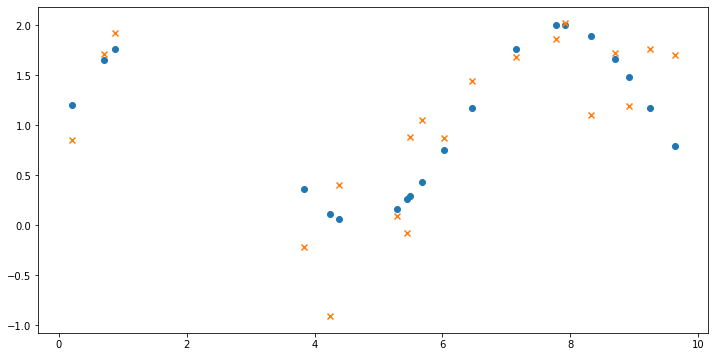

In [3]:
np.random.seed(0)
x_values = np.random.uniform(0,10,size=(20,1))
y_values = np.sin(x_values)+1
y_noisy = y_values+np.random.normal(size=(20,1),scale=0.4)
plt.scatter(x_values,y_values)
plt.scatter(x_values,y_noisy,marker='x')

x_test = np.linspace(0,10,100)[:,None]
y_test = np.sin(x_test)+1
#plt.scatter(x_test,y_test,marker='.')

In [4]:
#Initialize kernel, indicate lengthscale to initialize ARD
k = gpflow.kernels.SquaredExponential(lengthscale=[1]*x_values.shape[1])
print_summary(k)

m = gpflow.models.GPR(data=(x_values, y_noisy), kernel=k, mean_function=None)
m.likelihood.variance.assign(0.1)

name                            class      transform    prior    trainable    shape    dtype    value
------------------------------  ---------  -----------  -------  -----------  -------  -------  -------
SquaredExponential.variance     Parameter  Softplus              True         ()       float64  1.0
SquaredExponential.lengthscale  Parameter  Softplus              True         (1,)     float64  [1.]


In [5]:
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return - m.log_marginal_likelihood()

time_start = time.time()
opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print(f'Run time {time.time()-time_start}')

print_summary(m)

Run time 3.515692710876465
name                     class      transform                prior    trainable    shape    dtype    value
-----------------------  ---------  -----------------------  -------  -----------  -------  -------  -------------------
GPR.kernel.variance      Parameter  Softplus                          True         ()       float64  1.5501825154604947
GPR.kernel.lengthscale   Parameter  Softplus                          True         (1,)     float64  [1.82211272]
GPR.likelihood.variance  Parameter  Softplus + AffineScalar           True         ()       float64  0.17137105891046023


In [6]:
## predict mean and variance of latent GP at test points
mean, var = m.predict_f(x_test)
metrics = compute_metrics(mean.numpy(), y_test, y_values, fc_scale=2)
metrics

{'mae': 0.3499101237221632,
 'mse': 0.19054694001526254,
 'smse': 0.41512883227385555,
 'r2': 0.5687530638996783,
 'evs': 0.6280389672099872,
 'spearmanrho': 0.8119291929192918,
 'spearmanrho_p': 1.2138124710595914e-24,
 'pearsonr': 0.8138428837623174,
 'pearsonr_p': 7.726406708717138e-25,
 'median_abs_fc': 1.1975046856887566,
 'mean_abs_fc': 1.2744812278663538}

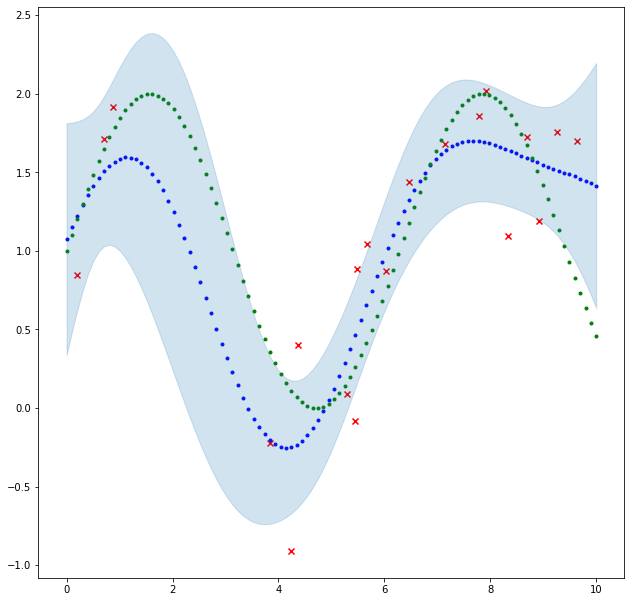

In [7]:
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

#plt.scatter(x_values,y_values,marker='o',color='r')
ax.scatter(x_values,y_noisy,marker='x',color='r')
ax.scatter(x_test,mean.numpy(),marker='.',color='b')
ax.scatter(x_test,y_test,marker='.',color='g')

ax.fill_between(x_test[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

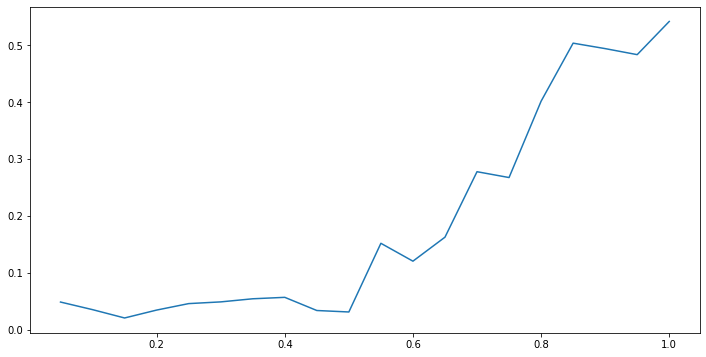

In [45]:
#plot mse, smse, and pearsonr for top 10% lowest variance to all, compute every 5% increments
sorted_indicies = np.argsort(var.numpy().squeeze())
sorted_mean = mean.numpy()[sorted_indicies]
sorted_ytruth = y_test[sorted_indicies]

scores=[]

intervals = np.arange(.05,1.05,0.05)
index_old=0

for percent in intervals:
    index = int(np.floor(sorted_mean.shape[0]*percent))
    top_means = sorted_mean[index_old:index]
    top_means_ytruth = sorted_ytruth[index_old:index]
    scores.append(compute_metrics(top_means, top_means_ytruth, y_values, fc_scale=2)['mse'])
    index_old=index
    #print(metrics.mean_squared_error(top_means_ytruth,top_means))
    
plt.plot(intervals,scores)

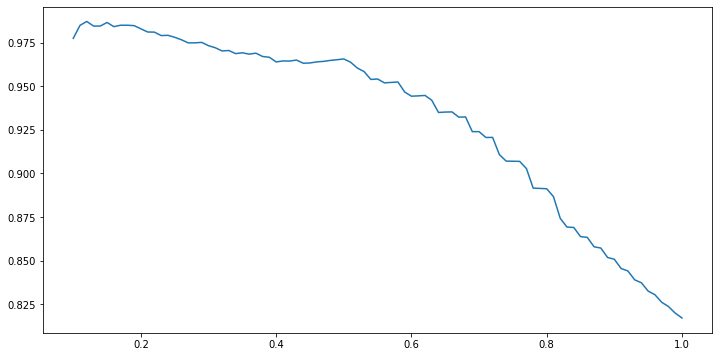

In [9]:
#plot mse, smse, and pearsonr for top 10% lowest variance to all, compute every 5% increments
sorted_indicies = np.argsort(var.numpy().squeeze())
sorted_mean = mean.numpy()[sorted_indicies]
sorted_ytruth = y_test[sorted_indicies]

scores=[]

intervals = np.arange(.1,1.01,0.01)
for percent in intervals:
    index = int(np.floor(sorted_mean.shape[0]*percent))
    top_means = sorted_mean[0:index]
    top_means_ytruth = sorted_ytruth[0:index]
    scores.append(compute_metrics(top_means, top_means_ytruth, y_values, fc_scale=2)['pearsonr'])
    #print(metrics.mean_squared_error(top_means_ytruth,top_means))
    
plt.plot(intervals,scores)

Text(0.75, 0.01, 'pearson r: 0.5992')

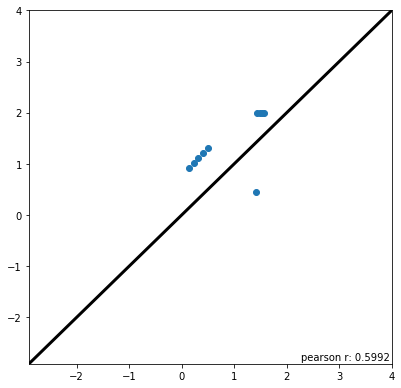

In [10]:
percent=.9
lower_percent=0.8
index = int(np.floor(sorted_mean.shape[0]*percent))
lower_index = int(np.floor(sorted_mean.shape[0]*lower_percent))
top_means = sorted_mean[lower_index:index]
top_means_ytruth = sorted_ytruth[lower_index:index]

fig = plt.figure()
fig.set_size_inches(6.5,6.5)
ax = fig.add_subplot(111)

ax.scatter(top_means,top_means_ytruth)
y_max = int(y_noisy.max())+2
y_min = y_noisy.min()-2
ax.set_xlim(y_min,y_max)
ax.set_ylim(y_min,y_max)

x = np.linspace(*ax.get_xlim())
# ax.plot([0,1],[0,1], transform=ax.transAxes)
ax.plot(x, x,color='k',linewidth=3)

pearson = scipy.stats.pearsonr(top_means_ytruth.squeeze(),top_means.squeeze())[0]
ax.text(.75,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)

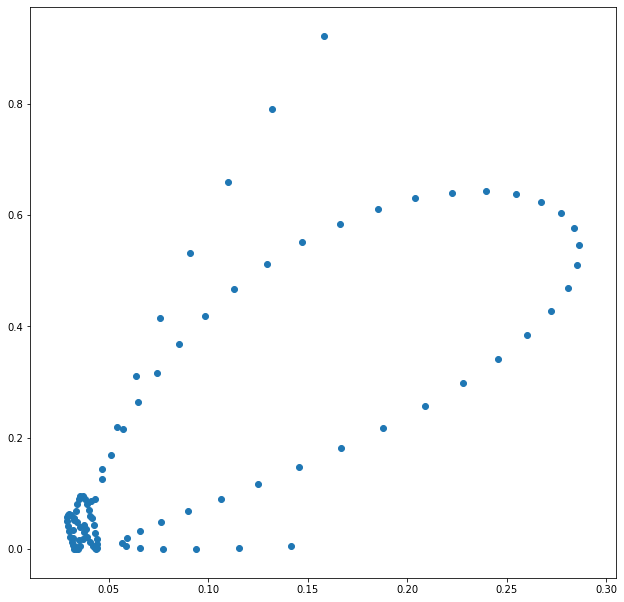

In [11]:
sorted_var = var.numpy()[sorted_indicies]
sorted_squared_error = []
for single_mean,single_true in zip(sorted_mean.squeeze(),sorted_ytruth.squeeze()):
    sorted_squared_error.append((single_mean-single_true)**2)
    
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
ax.scatter(sorted_var.squeeze(),sorted_squared_error)

Text(0.75, 0.01, 'pearson r: 0.8138')

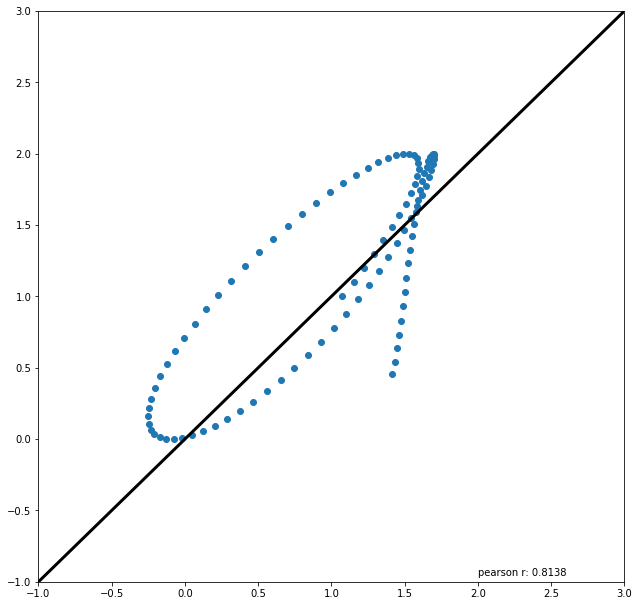

In [12]:
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(mean.numpy(),y_test)
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)

x = np.linspace(*ax.get_xlim())
# ax.plot([0,1],[0,1], transform=ax.transAxes)
ax.plot(x, x,color='k',linewidth=3)

pearson = scipy.stats.pearsonr(y_test.squeeze(),mean.numpy().squeeze())[0]
ax.text(.75,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)